In [2]:
import geopandas as gpd
import fiona
import pandas as pd
import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
from shapely import points
import skimage
fiona.supported_drivers["KML"] ='rw'

In [3]:
#A function to calculate the row and column number of point coordinates on a raster image
def loc_to_pix_num(rasterBounds, x, y):
  '''it requires the bounds of the raster image'''
  minx, miny, maxx, maxy = rasterBounds
  if minx<x<maxx and miny<y<maxy:
    row    = int(np.round(maxy-y))
    column = int(np.round(x-minx))
    return (row, column)
  else:
    return "The position is out of bounds"

def get_grd_bounds(path):
  f = open(path)
  cornerSigns = ["NW", "SW", "SE", "NE"]
  corners = list()
  rawText = f.readlines()
  for sign in cornerSigns:
    for line in rawText:
      if line.find(sign)!=-1:
        x, y = line.split(' ')[2:4]
        corners.append([float(x[1:-1]), float(y[:-1])])
  return Polygon(corners).bounds

#A function to calculate point coordinates for a row and a column number
def pix_to_loc(rasterBounds, row, column):
  minx, miny, maxx, maxy = rasterBounds
  y = maxy - row
  x = column + minx
  return (x, y)



In [4]:
#Data
#The location and attributes of transmitters
sectors    = pd.read_excel('Data/Sample2G_Tehran.xlsx')

#Cell radius data
cellRanges = pd.read_csv('Data/CellRange.csv')

#3D height data of the environment
DTM_grd = gdal.Open('Data/Height/DTM/DTM_1m.grd')
DSM_grd = gdal.Open('Data/Height/DSM/DSM_1m.grd')

#3D data to numpy array
DTM = DTM_grd.ReadAsArray()[3]
DSM = DSM_grd.ReadAsArray()[3]

#Transmitters and their range combination
temp_ = cellRanges[['sourceCellName', 'cellRange1']].copy()
temp_ ['Transmitter'] = temp_.sourceCellName
sectors_gdf = sectors.merge(temp_ [['Transmitter', 'cellRange1']], on='Transmitter')
sectors_gdf['Tilt'] = sectors_gdf['Mechanical Downtilt']+sectors_gdf['Electrical Tilt']
Transmitters = gpd.GeoDataFrame(sectors_gdf [['Site', 'Transmitter', 'Longitude', 'Latitude', 'Height (m)', 'Azimuth', 'cellRange1', 'Tilt']], geometry=points(sectors_gdf[['Longitude',	'Latitude']].values), crs=4326)
Transmitters = Transmitters.to_crs(32639)

#remove sectors without range
Transmitters = Transmitters.loc[~Transmitters.cellRange1.isna()]

#3D data bounds
dtmBounds = get_grd_bounds('Data/Height/DTM/DTM_1m.tab')
dsmBounds = get_grd_bounds('Data/Height/DSM/DSM_1m.tab')
clutterBounds = get_grd_bounds('Data/Cluter/Cluter_1meter_Indexed.tab')

In [4]:
rscp_file = gpd.read_file('Mun4_3G_Idle(RSCP-SC)_2G(CellId)/Mun4_3G_Idle(RSCP-SC)_2G(CellId)/Mun4 - MS1-ServRxLevIdle -85.kml', driver='KML')
descs = []
for desc in rscp_file.Description:
    descs.append(float(desc.split(' ')[1]))

RSCP           = rscp_file[['geometry']].copy()
RSCP['rscp']   = descs
RSCP['Lon']    = RSCP.geometry.x.values
RSCP['Lat']    = RSCP.geometry.y.values

In [5]:
cids = gpd.read_file('Mun4_3G_Idle(RSCP-SC)_2G(CellId)/Mun4_3G_Idle(RSCP-SC)_2G(CellId)/Mun4_MS1-ServCI.kml', driver='KML')
descs = []
for desc in cids.Description:
    descs.append(int(desc.split(' ')[1]))

CID = cids[['geometry']].copy()
CID['cid'] = descs
CID['Lon'] = CID.geometry.x.values
CID['Lat'] = CID.geometry.y.values

In [6]:
uni_rscp   = RSCP.groupby(['Lon','Lat']).size().reset_index().rename(columns={0:'count'})
raw_cids   = []
drive_lons = []
drive_lats = []
raw_rscp   = []
for drive_loc in uni_rscp[['Lon','Lat']].values:
   drive_loc_lon, drive_loc_lat = drive_loc
   drive_cid = CID.loc[(CID.Lon==drive_loc_lon) & (CID.Lat==drive_loc_lat)]
   if len(drive_cid)>0:
    raw_cids.append(drive_cid.cid.values[0])
    drive_lons.append(drive_loc_lon)
    drive_lats.append(drive_loc_lat)
    raw_rscp.append(RSCP.loc[(RSCP.Lon==drive_loc_lon) & (RSCP.Lat==drive_loc_lat)].rscp.mean())

In [7]:
drive_dataset = gpd.GeoDataFrame(data={'Rscp':raw_rscp,'Cid': raw_cids}, geometry=gpd.points_from_xy(x=drive_lons, y=drive_lats, crs=4326))

In [8]:
sector_dic = {'1':'A', '2':'B', '3':'C', '4':'D', '5':'E', '6':'F', '7':'G', '8':'H'}

cid_siteName = pd.read_excel('TH_CID.xlsx', sheet_name='Cell ID')
raw_siteNames = []
raw_transmitters = []

for cid in drive_dataset.Cid:
    try:
        site_nm = cid_siteName.loc[cid_siteName.CELL_ID==int(str(cid)[1:])].Site.values[0]
        raw_siteNames.append(site_nm)
        raw_transmitters.append(site_nm + sector_dic[str(cid)[0]])
    except:
        raw_siteNames.append('unknown')
        raw_transmitters.append('unknown')

In [9]:
drive_dataset['Site'] = raw_siteNames
drive_dataset['Transmitter'] = raw_transmitters

In [10]:
citeName_Loc =  pd.read_excel('TH_CID.xlsx', sheet_name=1)

In [11]:
cell_lon, cell_lat = [], []
for site in drive_dataset['Site']:
    try:
        name, lon, lat = citeName_Loc.loc[citeName_Loc.Name==site].values[0]
        cell_lon.append(lon)
        cell_lat.append(lat)
    except:
        cell_lon.append('unknown')
        cell_lat.append('unknown')

In [12]:
drive_dataset['drive_lon'] = drive_dataset.geometry.x
drive_dataset['drive_lat'] = drive_dataset.geometry.y
drive_dataset['cell_lon']  = cell_lon
drive_dataset['cell_lat']  = cell_lat

In [13]:
cell_height =  pd.read_excel('TH_CID.xlsx', sheet_name=2)

In [14]:
raw_heights = []
for transm in drive_dataset.Transmitter:
    try:
        raw_heights.append(cell_height.loc[cell_height.Transmitter==transm]['Height (m)'].values[0])
    except:
        raw_heights.append('unknown')

In [15]:
drive_dataset['cell_height'] = raw_heights

In [16]:
drive_dataset = drive_dataset.loc[drive_dataset.Site != 'unknown'].copy()

In [17]:
drive_dataset['cell_x'] = gpd.points_from_xy(x = drive_dataset.cell_lon, y = drive_dataset.cell_lat, crs=4326).to_crs(32639).x
drive_dataset['cell_y'] = gpd.points_from_xy(x = drive_dataset.cell_lon, y = drive_dataset.cell_lat, crs=4326).to_crs(32639).y
drive_dataset['drive_x'] = gpd.points_from_xy(x = drive_dataset.drive_lon, y = drive_dataset.drive_lat, crs=4326).to_crs(32639).x
drive_dataset['drive_y'] = gpd.points_from_xy(x = drive_dataset.drive_lon, y = drive_dataset.drive_lat, crs=4326).to_crs(32639).y

In [18]:
drive_dataset = drive_dataset.reset_index(drop=True)

In [20]:
drive_dataset.to_excel('Drive.xlsx')

In [21]:
drv = pd.read_excel('Drive.xlsx')

In [23]:
drv

,Unnamed: 0,Rscp,Cid,geometry,Site,Transmitter,drive_lon,drive_lat,cell_lon,cell_lat,cell_height,cell_x,cell_y,drive_x,drive_y
0,0,-56.5,15129,POINT (51.447004 35.742588),TH1469,TH1469A,51.447004,35.742588,51.44613,35.73996,34.0,540340.355018,3.955199e+06,540418.056796,3.955490e+06
1,1,-56.5,15129,POINT (51.447005 35.742519),TH1469,TH1469A,51.447005,35.742519,51.44613,35.73996,34.0,540340.355018,3.955199e+06,540418.182094,3.955483e+06
2,2,-56.5,15129,POINT (51.447006 35.742629),TH1469,TH1469A,51.447006,35.742629,51.44613,35.73996,34.0,540340.355018,3.955199e+06,540418.216913,3.955495e+06
3,3,-58.0,15129,POINT (51.447012 35.74271),TH1469,TH1469A,51.447012,35.742710,51.44613,35.73996,34.0,540340.355018,3.955199e+06,540418.718492,3.955504e+06
4,4,-56.0,15129,POINT (51.447015 35.742481),TH1469,TH1469A,51.447015,35.742481,51.44613,35.73996,34.0,540340.355018,3.955199e+06,540419.105508,3.955479e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54825,54825,-48.0,42922,POINT (51.633096 35.732786),TH0491,TH0491D,51.633096,35.732786,51.63579,35.73027,38.0,557497.114038,3.954218e+06,557251.680545,3.954496e+06
54826,54826,-48.0,42922,POINT (51.633106 35.732233),TH0491,TH0491D,51.633106,35.732233,51.63579,35.73027,38.0,557497.114038,3.954218e+06,557252.980681,3.954435e+06
54827,54827,-48.0,42922,POINT (51.633128 35.73265),TH0491,TH0491D,51.633128,35.732650,51.63579,35.73027,38.0,557497.114038,3.954218e+06,557254.671730,3.954481e+06
54828,54828,-48.0,42922,POINT (51.633132 35.732389),TH0491,TH0491D,51.633132,35.732389,51.63579,35.73027,38.0,557497.114038,3.954218e+06,557255.220280,3.954452e+06


In [20]:
from shapely import linestrings

In [21]:
cells_xy = np.column_stack((drive_dataset.cell_x, drive_dataset.cell_y))

In [22]:
drive_xy = np.column_stack((drive_dataset.drive_x, drive_dataset.drive_y))

In [23]:
stacked = np.hstack((cells_xy, drive_xy))
stacked_rshp = stacked.reshape((stacked.shape[0], 2 , 2))

In [24]:
line_type_dataset = gpd.GeoDataFrame(data = drive_dataset ,geometry=linestrings(stacked_rshp), crs=32639)

In [25]:
minx = line_type_dataset.bounds.minx.min()
miny = line_type_dataset.bounds.miny.min()
maxx = line_type_dataset.bounds.maxx.max()
maxy = line_type_dataset.bounds.maxy.max()

<Axes: >

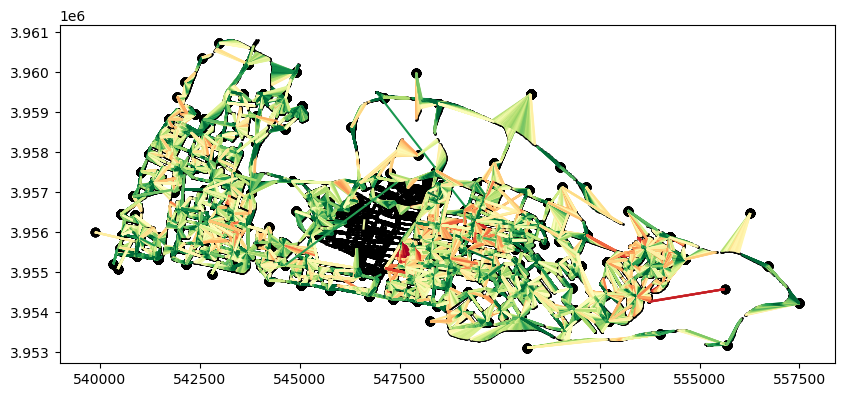

In [26]:
ax = RSCP.to_crs(32639).clip(Polygon(((minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)))).plot(figsize=(10,10), markersize=1, color='black', legend= True)
line_type_dataset.plot(ax=ax, column='Rscp', cmap='RdYlGn', zorder=10)
gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=drive_dataset.cell_x, y = drive_dataset.cell_y, crs =32639)).plot(ax=ax, color='black')

In [ ]:
line_type_dataset.explore(column='Rscp', cmap='RdYlGn')

In [165]:
dsmBounds

(545019.228012, 3952757.9942, 556506.228099, 3962867.994299)

In [45]:
drv

,Unnamed: 0,Rscp,Cid,geometry,Site,Transmitter,drive_lon,drive_lat,cell_lon,cell_lat,cell_height,cell_x,cell_y,drive_x,drive_y
0,0,-56.5,15129,POINT (51.447004 35.742588),TH1469,TH1469A,51.447004,35.742588,51.44613,35.73996,34.0,540340.355018,3.955199e+06,540418.056796,3.955490e+06
1,1,-56.5,15129,POINT (51.447005 35.742519),TH1469,TH1469A,51.447005,35.742519,51.44613,35.73996,34.0,540340.355018,3.955199e+06,540418.182094,3.955483e+06
2,2,-56.5,15129,POINT (51.447006 35.742629),TH1469,TH1469A,51.447006,35.742629,51.44613,35.73996,34.0,540340.355018,3.955199e+06,540418.216913,3.955495e+06
3,3,-58.0,15129,POINT (51.447012 35.74271),TH1469,TH1469A,51.447012,35.742710,51.44613,35.73996,34.0,540340.355018,3.955199e+06,540418.718492,3.955504e+06
4,4,-56.0,15129,POINT (51.447015 35.742481),TH1469,TH1469A,51.447015,35.742481,51.44613,35.73996,34.0,540340.355018,3.955199e+06,540419.105508,3.955479e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54825,54825,-48.0,42922,POINT (51.633096 35.732786),TH0491,TH0491D,51.633096,35.732786,51.63579,35.73027,38.0,557497.114038,3.954218e+06,557251.680545,3.954496e+06
54826,54826,-48.0,42922,POINT (51.633106 35.732233),TH0491,TH0491D,51.633106,35.732233,51.63579,35.73027,38.0,557497.114038,3.954218e+06,557252.980681,3.954435e+06
54827,54827,-48.0,42922,POINT (51.633128 35.73265),TH0491,TH0491D,51.633128,35.732650,51.63579,35.73027,38.0,557497.114038,3.954218e+06,557254.671730,3.954481e+06
54828,54828,-48.0,42922,POINT (51.633132 35.732389),TH0491,TH0491D,51.633132,35.732389,51.63579,35.73027,38.0,557497.114038,3.954218e+06,557255.220280,3.954452e+06


Section 2

In [26]:
DSM

array([[-1.e+37, -1.e+37, -1.e+37, ..., -1.e+37, -1.e+37, -1.e+37],
       [-1.e+37, -1.e+37, -1.e+37, ..., -1.e+37, -1.e+37, -1.e+37],
       [-1.e+37, -1.e+37, -1.e+37, ..., -1.e+37, -1.e+37, -1.e+37],
       ...,
       [-1.e+37, -1.e+37, -1.e+37, ..., -1.e+37, -1.e+37, -1.e+37],
       [-1.e+37, -1.e+37, -1.e+37, ..., -1.e+37, -1.e+37, -1.e+37],
       [-1.e+37, -1.e+37, -1.e+37, ..., -1.e+37, -1.e+37, -1.e+37]],
      dtype=float32)

In [46]:
cell_y = drv.cell_y.values
cell_x = drv.cell_x.values
drive_y = drv.drive_y.values
drive_x = drv.drive_x.values

In [63]:
minx, miny, maxx, maxy = dsmBounds
a = (minx<cell_x) & (cell_x<maxx) & (miny<cell_y) & (cell_y<maxy)
b = (minx<drive_x) & (drive_x<maxx) & (miny<drive_y) & (drive_y<maxy)

In [64]:
a&b

array([False, False, False, ..., False, False, False])

In [65]:
drv.loc[a&b]

,Unnamed: 0,Rscp,Cid,geometry,Site,Transmitter,drive_lon,drive_lat,cell_lon,cell_lat,cell_height,cell_x,cell_y,drive_x,drive_y,cell_pix_row,cell_pix_col,drive_pix_row,drive_pix_col
20296,20296,-73.0,34878,POINT (51.497857 35.736864),TH1738,TH1738C,51.497857,35.736864,51.503260,35.737150,30.5,545507.852722,3.954912e+06,545019.437382,3.954878e+06,7956,489,7990,0
20305,20305,-69.0,21108,POINT (51.497888 35.739217),TH0064,TH0064B,51.497888,35.739217,51.499970,35.740690,28.5,545208.347125,3.955303e+06,545020.916010,3.955139e+06,7565,189,7729,2
20308,20308,-52.0,20580,POINT (51.497901 35.735418),TH0580,TH0580B,51.497901,35.735418,51.498040,35.735160,32.0,545036.945062,3.954689e+06,545024.230183,3.954717e+06,8179,18,8151,5
20316,20316,-70.5,21108,POINT (51.497927 35.739947),TH0064,TH0064B,51.497927,35.739947,51.499970,35.740690,28.5,545208.347125,3.955303e+06,545024.031567,3.955220e+06,7565,189,7648,5
20317,20317,-49.0,31108,POINT (51.497927 35.741184),TH0064,TH0064C,51.497927,35.741184,51.499970,35.740690,32.0,545208.347125,3.955303e+06,545023.335104,3.955357e+06,7565,189,7511,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54687,54687,-55.0,19883,POINT (51.61922 35.726364),TH3017,TH3017A,51.619220,35.726364,51.615637,35.721002,45.5,555681.021656,3.953179e+06,556001.335701,3.953776e+06,9689,10662,9092,10982
54688,54688,-56.0,19883,POINT (51.619331 35.726484),TH3017,TH3017A,51.619331,35.726484,51.615637,35.721002,45.5,555681.021656,3.953179e+06,556011.290493,3.953789e+06,9689,10662,9079,10992
54689,54689,-57.5,19883,POINT (51.619511 35.726667),TH3017,TH3017A,51.619511,35.726667,51.615637,35.721002,45.5,555681.021656,3.953179e+06,556027.441453,3.953809e+06,9689,10662,9059,11008
54690,54690,-58.0,19883,POINT (51.619665 35.726817),TH3017,TH3017A,51.619665,35.726817,51.615637,35.721002,45.5,555681.021656,3.953179e+06,556041.264037,3.953826e+06,9689,10662,9042,11022


In [47]:
minx, miny, maxx, maxy = dsmBounds
cells_row    = np.int32(np.round(maxy-cell_y))
cells_column = np.int32(np.round(cell_x-minx))

drive_row    = np.int32(np.round(maxy-drive_y))
drive_column = np.int32(np.round(drive_x-minx))


In [49]:
drv['cell_pix_row'] = cells_row
drv['cell_pix_col'] = cells_column
drv['drive_pix_row'] = drive_row
drv['drive_pix_col'] = drive_column

In [ ]:
drv

In [66]:
drive_test = drv.loc[a&b].copy()

In [68]:
drive_test = drive_test.reset_index(drop=True)

In [69]:
drive_test

,Unnamed: 0,Rscp,Cid,geometry,Site,Transmitter,drive_lon,drive_lat,cell_lon,cell_lat,cell_height,cell_x,cell_y,drive_x,drive_y,cell_pix_row,cell_pix_col,drive_pix_row,drive_pix_col
0,20296,-73.0,34878,POINT (51.497857 35.736864),TH1738,TH1738C,51.497857,35.736864,51.503260,35.737150,30.5,545507.852722,3.954912e+06,545019.437382,3.954878e+06,7956,489,7990,0
1,20305,-69.0,21108,POINT (51.497888 35.739217),TH0064,TH0064B,51.497888,35.739217,51.499970,35.740690,28.5,545208.347125,3.955303e+06,545020.916010,3.955139e+06,7565,189,7729,2
2,20308,-52.0,20580,POINT (51.497901 35.735418),TH0580,TH0580B,51.497901,35.735418,51.498040,35.735160,32.0,545036.945062,3.954689e+06,545024.230183,3.954717e+06,8179,18,8151,5
3,20316,-70.5,21108,POINT (51.497927 35.739947),TH0064,TH0064B,51.497927,35.739947,51.499970,35.740690,28.5,545208.347125,3.955303e+06,545024.031567,3.955220e+06,7565,189,7648,5
4,20317,-49.0,31108,POINT (51.497927 35.741184),TH0064,TH0064C,51.497927,35.741184,51.499970,35.740690,32.0,545208.347125,3.955303e+06,545023.335104,3.955357e+06,7565,189,7511,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34058,54687,-55.0,19883,POINT (51.61922 35.726364),TH3017,TH3017A,51.619220,35.726364,51.615637,35.721002,45.5,555681.021656,3.953179e+06,556001.335701,3.953776e+06,9689,10662,9092,10982
34059,54688,-56.0,19883,POINT (51.619331 35.726484),TH3017,TH3017A,51.619331,35.726484,51.615637,35.721002,45.5,555681.021656,3.953179e+06,556011.290493,3.953789e+06,9689,10662,9079,10992
34060,54689,-57.5,19883,POINT (51.619511 35.726667),TH3017,TH3017A,51.619511,35.726667,51.615637,35.721002,45.5,555681.021656,3.953179e+06,556027.441453,3.953809e+06,9689,10662,9059,11008
34061,54690,-58.0,19883,POINT (51.619665 35.726817),TH3017,TH3017A,51.619665,35.726817,51.615637,35.721002,45.5,555681.021656,3.953179e+06,556041.264037,3.953826e+06,9689,10662,9042,11022


In [70]:
from scipy.sparse.csgraph import shortest_path

In [71]:
drive_test.to_excel('drv2.xlsx')

Section 3

In [3]:
drive_test = pd.read_excel('drv2.xlsx')

In [9]:
cols = ['Rscp', 'Cid', 'geometry', 'Site',
       'Transmitter', 'drive_lon', 'drive_lat', 'cell_lon', 'cell_lat',
       'cell_height', 'cell_x', 'cell_y', 'drive_x', 'drive_y', 'cell_pix_row',
       'cell_pix_col', 'drive_pix_row', 'drive_pix_col']

In [12]:
drive_test[cols].to_excel('Drive_dataset.xlsx')

In [ ]:
drive_test[cols]

HERE

In [5]:
Drive = pd.read_excel('drv2.xlsx')

In [ ]:
Clutter_grc = gdal.Open('Data/Cluter/Cluter_1meter_Indexed.grc')
clutter = Clutter_grc.ReadAsArray()

clutter_minx, clutter_miny, clutter_maxx, clutter_maxy = clutterBounds
dsm_minx, dsm_miny, dsm_maxx, dsm_maxy = dsmBounds

In [ ]:
clmns = ['clutter_'+str(i) for i in range(20)]
clmns.append('All_distance')
Output = pd.DataFrame(columns=clmns)

In [ ]:
for i, cell_height, cell_pix_row, cell_pix_col, drive_pix_row, drive_pix_col in zip(range(len(Drive.cell_height)),Drive.cell_height, Drive.cell_pix_row, Drive.cell_pix_col, Drive.drive_pix_row, Drive.drive_pix_col):
    print(i)
    line_r, line_c = skimage.draw.line(cell_pix_row, cell_pix_col, drive_pix_row, drive_pix_col)
    if not (DSM[line_r, line_c]<0).any():
        square = np.square(np.vstack((line_r, line_c)).T - np.array([cell_pix_row, cell_pix_col]))
        sum = np.sum(square, axis=1)
        dist2org = np.sqrt(sum)
        Cell_pix_height  = DTM [cell_pix_row, cell_pix_col] + cell_height
        Drive_pix_height = DTM [drive_pix_row, drive_pix_col]
        heights = DTM [cell_pix_row, cell_pix_col] + (Cell_pix_height - Drive_pix_height) - (dist2org * (Cell_pix_height - Drive_pix_height) / dist2org[-1])
        intersecteds = heights < DSM [line_r, line_c]
        temp = np.zeros_like(DSM)
        temp [line_r[intersecteds] , line_c[intersecteds]] = 1
        int_r, int_c = np.nonzero(temp)
        int_x = int_c + dsm_minx 
        int_y = dsm_maxy - int_r
        if ((clutter_minx<int_x) & (int_x<clutter_maxx) & (clutter_miny<int_y) & (int_y<clutter_maxy)).all():
            clut_r = np.int32(np.round(clutter_maxy-int_y))
            clut_c = np.int32(np.round(int_x-clutter_minx))
            if not (clutter[clut_r, clut_c]==20).any():
                temp_list=[]
                for i in range(20):
                    temp_list.append(len(np.nonzero(clutter[clut_r, clut_c]==i)[0]))
                temp_list.append(len(line_r))
                Output.loc[len(Output)] = temp_list

In [104]:
Output.to_csv('output1.csv')

###################################################

In [7]:
square = np.square(np.vstack((line_r, line_c)).T - np.array([cell_pix_row, cell_pix_col]))
sum = np.sum(square, axis=1)
dist2org = np.sqrt(sum)

In [8]:
Cell_pix_height  = DTM [cell_pix_row, cell_pix_col] + cell_height
Drive_pix_height = DTM [drive_pix_row, drive_pix_col]

In [9]:
heights = DTM [cell_pix_row, cell_pix_col] + (Cell_pix_height - Drive_pix_height) - (dist2org * (Cell_pix_height - Drive_pix_height) / dist2org[-1])

In [10]:
intersecteds = heights < DSM [line_r, line_c]

In [11]:
Clutter_grc = gdal.Open('Data/Cluter/Cluter_1meter_Indexed.grc')

In [12]:
clutter = Clutter_grc.ReadAsArray()

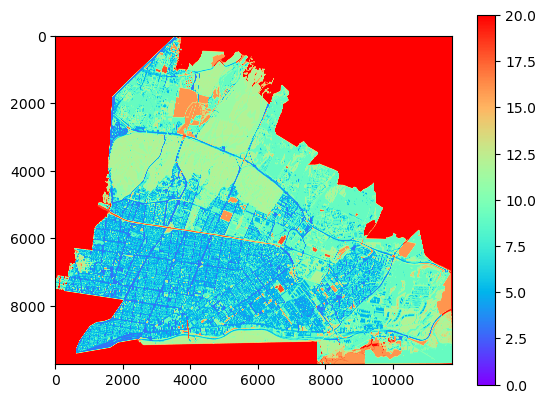

In [54]:
plt.imshow(clutter, cmap='rainbow')
plt.colorbar()

In [38]:
clutter_minx, clutter_miny, clutter_maxx, clutter_maxy = clutterBounds
dsm_minx, dsm_miny, dsm_maxx, dsm_maxy = dsmBounds

In [29]:
temp = np.zeros_like(DSM)
temp [line_r[intersecteds] , line_c[intersecteds]] = 1

In [39]:
int_r, int_c = np.nonzero(temp)
int_x = int_c + dsm_minx 
int_y = dsm_maxy - int_r

In [49]:
if ((clutter_minx<int_x) & (int_x<clutter_maxx) & (clutter_miny<int_y) & (int_y<clutter_maxy)).all():
    clut_r = np.int32(np.round(clutter_maxy-int_y))
    clut_c = np.int32(np.round(int_x-clutter_minx))
clut_r, clut_c

(array([7357, 7357, 7357, 7358, 7359, 7359, 7359, 7359, 7360, 7360, 7360,
        7360, 7360, 7360, 7361, 7368, 7373, 7373, 7373, 7373, 7378, 7378,
        7378, 7378, 7378, 7378, 7379, 7379, 7379, 7379, 7379, 7379, 7379,
        7380, 7380, 7380, 7380, 7380, 7380, 7380, 7380, 7381, 7381, 7381,
        7381, 7381, 7382, 7382, 7382, 7382, 7382, 7382, 7382, 7383, 7383,
        7383, 7383, 7383, 7383, 7383, 7383, 7384, 7384, 7384, 7384, 7384,
        7384, 7384, 7386, 7386, 7386, 7386, 7386, 7387, 7387, 7387, 7387,
        7387, 7387, 7387, 7388, 7388, 7388, 7388, 7388, 7388, 7388, 7389,
        7389, 7389, 7389, 7389, 7389, 7389, 7389, 7390, 7390, 7390, 7391,
        7391, 7391, 7391]),
 array([607, 608, 609, 606, 592, 593, 594, 595, 586, 587, 588, 589, 590,
        591, 584, 527, 490, 491, 492, 495, 453, 454, 455, 456, 457, 458,
        446, 447, 448, 449, 450, 451, 452, 438, 439, 440, 441, 442, 443,
        444, 445, 431, 432, 433, 434, 435, 424, 425, 426, 427, 428, 429,
        430, 4

In [77]:
if not (clutter[clut_r, clut_c]==20).any():
    temp_list=[]
    for i in range(20):
        temp_list.append(len(np.nonzero(clutter[clut_r, clut_c]==i)[0]))
        temp_list.append(len(line_r))

In [95]:
clmns = ['clutter_'+str(i) for i in range(20)]
clmns.append('All_distance')
Output = pd.DataFrame(columns=clmns)
Output.loc[len(Output)] = temp_list

In [96]:
Output.loc[len(Output)] = temp_list
Output

,clutter_0,clutter_1,clutter_2,clutter_3,clutter_4,clutter_5,clutter_6,clutter_7,clutter_8,clutter_9,...,clutter_11,clutter_12,clutter_13,clutter_14,clutter_15,clutter_16,clutter_17,clutter_18,clutter_19,All_distance
0,17,0,0,7,0,34,0,0,7,22,...,0,0,0,0,0,0,15,0,0,382


In [92]:
temp_list

[17, 0, 0, 7, 0, 34, 0, 0, 7, 22, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 382]

In [73]:
temp_list=[]
for i in range(20):
    temp_list.append(len(np.nonzero(clutter[clut_r, clut_c]==i)[0]))